## A better secular equation solver

Until now I have been unable to perform temporal instanton anlysis on the Polish grid. There is something about it that makes it more difficult than other networks. No line has an instanton solution, so the `score` vector is just a vector with `nothing` entries. I believe this may be traced to a shortcoming in `solve_secular`.

I begin by loading the Polish grid summer peak Matpower case to demonstrate the problem:

In [1]:
# single proc
include("../src/TemporalInstanton.jl")
using TemporalInstanton

In [1]:
# two worker procs
addprocs(2)
@everywhere include("../src/TemporalInstanton.jl")
@everywhere using TemporalInstanton;

In [2]:
using MatpowerCases, HDF5, JLD

""" 20150-09-06. Modified version of mat2tmpinst.
Load (and generate) everything needed to perform temporal 
instanton analysis for any network supported by MatpowerCases.

* `num_wind_farms`: how many wind farms do you want?
* `wind_penetration`: desired value of sum(G0)/sum(R0)

Note: each wind farm's output is sum(Gp)*wind_penetration/num_wind_farms
"""
function mat2tmpinst(
    name::ASCIIString,
    num_wind_farms::Int64,
    wind_penetration::Float64;
    return_as_type::Bool = true
    )
    mpc = loadcase(name,describe=false)
    
    bus_orig = mpc["bus"][:,1]
    bus_simple = collect(1:length(bus_orig))
    
    genBus = mpc["gen"][:,1]
    for i in bus_simple
        genBus[genBus.==bus_orig[i]] = bus_simple[i]
    end
    
    try
        Sb = mpc["baseMVA"]
    catch
        warn("Base MVA missing from mpc data.")
        Sb = 100.0
    end
    Gp_long = mpc["gen"][:,2]

    f = round(Int64,mpc["branch"][:,1]) # "from bus" ...
    t = round(Int64,mpc["branch"][:,2]) # ... "to bus"
    for i in bus_simple
        f[f.==bus_orig[i]] = bus_simple[i]
        t[t.==bus_orig[i]] = bus_simple[i]
    end    
    r = mpc["branch"][:,3]              # resistance, pu
    x = mpc["branch"][:,4]              # reactance, pu
    b = mpc["branch"][:,5]              # susceptance, pu

    Y = createY(f,t,x)

    Gp = zeros(length(bus_simple))
    for i in bus_simple
        Gp[convert(Int64,i)] = sum(Gp_long[find(genBus.==i)])/Sb
    end

    Dp = mpc["bus"][:,3]./Sb
    
    # convert generators into wind farms:
    windsize = sum(Gp)*wind_penetration/num_wind_farms
#     Ridx = rand(1:length(Gp),num_wind_farms)
    Ridx = sortperm(Gp + Dp)[1:num_wind_farms]
    
    Rp = zeros(length(Gp))
    Rp[Ridx] = windsize

    Sb = Sb*1e6 # convert from MW to W

    ref = 1

    lines = [(f[i],t[i]) for i in 1:length(f)]
    lines = convert(Array{Tuple{Int64,Int64},1},lines)

#     res = r
#     reac = x

    # Allow each generator to participate equally in droop response.
    k = Float64[]
    for i = 1:length(Gp)
        if Gp[i] != 0
            push!(k, 1/length(find(Gp)))
        else
            push!(k,0)
        end
    end

    # use RTS-96 line lengths to generate similar line lengths
    line_lengths = load("../data/polish_line_lengths.jld","line_lengths")[1:length(lines)]

    # temporary (re-use rts-96 line conductor parameters)
    line_conductors = fill("waxwing",length(line_lengths))
    if return_as_type
        return InstantonInputData(Ridx,Y,Gp,Dp,Rp,Sb,ref,lines,r,x,k,line_lengths,line_conductors,
        NaN,NaN,NaN,0.0:0.0,Array{Float64,2}())
    else
        return Ridx,Y,Gp,Dp,Rp,Sb,ref,lines,r,x,k,line_lengths,line_conductors
    end
end

mat2tmpinst (generic function with 1 method)

In [3]:
d = mat2tmpinst("case3120sp",200,0.5)

# Thermal model parameters:
d.Tamb = 35.0 # C
d.T0 = 60.0 #46.0 # initial line steady-state temp

d.time_values = 0.0:30.0:300.0 # five minutes in 30-sec steps
d.int_length = 300. # seconds = 5 min

Gp,Dp,Rp = d.G0,d.D0,d.R0
d.G0 = [0.7*Gp;0.7*Gp;0.7*Gp]#;0.7*Gp;0.7*Gp;0.7*Gp]
d.D0 = [0.9*Dp;0.9*Dp;0.9*Dp]#;0.9*Dp;0.9*Dp;0.9*Dp]
d.R0 = [Rp;1.1*Rp;1.2*Rp]#;1.3*Rp;1.4*Rp;1.5*Rp]

@time results = solve_temporal_instanton(d);

	From worker 3:	finished 1850/3693
	From worker 2:	finished 10/3693
	From worker 3:	finished 1860/3693
	From worker 3:	finished 1870/3693
	From worker 2:	finished 20/3693
	From worker 3:	finished 1880/3693


	From worker 2:	finished 30/3693


	From worker 3:	finished 1890/3693
	From worker 2:	finished 40/3693


	From worker 2:	finished 50/3693


	From worker 3:	finished 1900/3693


	From worker 2:	finished 60/3693
	From worker 3:	finished 1910/3693


	From worker 2:	finished 70/3693
	From worker 3:	finished 1920/3693


	From worker 2:	finished 80/3693
	From worker 3:	finished 1930/3693


	From worker 3:	finished 1940/3693


	From worker 2:	finished 90/3693
	From worker 3:	finished 1950/3693
	From worker 2:	finished 100/3693
	From worker 3:	finished 1960/3693


	From worker 3:	finished 1970/3693
	From worker 2:	finished 110/3693
	From worker 3:	finished 1980/3693
	From worker 2:	finished 120/3693
	From worker 3:	finished 1990/3693
	From worker 3:	finished 2000/3693


	From worker 2:	finished 130/3693


	From worker 3:	finished 2010/3693
	From worker 3:	finished 2020/3693
	From worker 2:	finished 140/3693
	From worker 3:	finished 2030/3693
	From worker 2:	finished 150/3693
	From worker 3:	finished 2040/3693


	From worker 2:	finished 160/3693


	From worker 3:	finished 2050/3693
	From worker 3:	finished 2060/3693
	From worker 2:	finished 170/3693


	From worker 3:	finished 2070/3693
	From worker 3:	finished 2080/3693
	From worker 2:	finished 180/3693
	From worker 3:	finished 2090/3693
	From worker 2:	finished 190/3693
	From worker 3:	finished 2100/3693


	From worker 2:	finished 200/3693


	From worker 3:	finished 2110/3693
	From worker 2:	finished 210/3693
	From worker 3:	finished 2120/3693


	From worker 2:	finished 220/3693
	From worker 3:	finished 2130/3693
	From worker 3:	finished 2140/3693
	From worker 2:	finished 230/3693


	From worker 3:	finished 2150/3693
	From worker 2:	finished 240/3693


	From worker 3:	finished 2160/3693
	From worker 2:	finished 250/3693
	From worker 3:	finished 2170/3693
	From worker 2:	finished 260/3693
	From worker 3:	finished 2180/3693
	From worker 2:	finished 270/3693


	From worker 3:	finished 2190/3693
	From worker 2:	finished 280/3693
	From worker 3:	finished 2200/3693
	From worker 2:	finished 290/3693


	From worker 3:	finished 2210/3693
	From worker 2:	finished 300/3693


	From worker 3:	finished 2220/3693


	From worker 2:	finished 310/3693
	From worker 3:	finished 2230/3693
	From worker 2:	finished 320/3693


	From worker 3:	finished 2240/3693
	From worker 2:	finished 330/3693
	From worker 3:	finished 2250/3693


	From worker 2:	finished 340/3693
	From worker 3:	finished 2260/3693


	From worker 2:	finished 350/3693
	From worker 3:	finished 2270/3693
	From worker 2:	finished 360/3693
	From worker 3:	finished 2280/3693
	From worker 2:	finished 370/3693


	From worker 3:	finished 2290/3693
	From worker 2:	finished 380/3693


	From worker 3:	finished 2300/3693
	From worker 2:	finished 390/3693


	From worker 3:	finished 2310/3693
	From worker 2:	finished 400/3693


	From worker 3:	finished 2320/3693


	From worker 2:	finished 410/3693


	From worker 3:	finished 2330/3693
	From worker 2:	finished 420/3693


	From worker 3:	finished 2340/3693
	From worker 2:	finished 430/3693


	From worker 2:	finished 440/3693
	From worker 3:	finished 2350/3693
	From worker 2:	finished 450/3693
	From worker 3:	finished 2360/3693
	From worker 2:	finished 460/3693
	From worker 3:	finished 2370/3693
	From worker 2:	finished 470/3693
	From worker 3:	finished 2380/3693
	From worker 2:	finished 480/3693


	From worker 3:	finished 2390/3693


	From worker 2:	finished 490/3693
	From worker 3:	finished 2400/3693
	From worker 2:	finished 500/3693
	From worker 3:	finished 2410/3693


	From worker 3:	finished 2420/3693
	From worker 2:	finished 510/3693


	From worker 3:	finished 2430/3693


	From worker 2:	finished 520/3693
	From worker 3:	finished 2440/3693
	From worker 2:	finished 530/3693
	From worker 3:	finished 2450/3693
	From worker 2:	finished 540/3693
	From worker 2:	finished 550/3693
	From worker 3:	finished 2460/3693
	From worker 2:	finished 560/3693
	From worker 3:	finished 2470/3693
	From worker 2:	finished 570/3693
	From worker 3:	finished 2480/3693
	From worker 2:	finished 580/3693
	From worker 3:	finished 2490/3693
	From worker 2:	finished 590/3693
	From worker 3:	finished 2500/3693
	From worker 2:	finished 600/3693
	From worker 3:	finished 2510/3693
	From worker 2:	finished 610/3693
	From worker 3:	finished 2520/3693
	From worker 2:	finished 620/3693
	From worker 3:	finished 2530/3693
	From worker 2:	finished 630/3693
	From worker 3:	finished 2540/3693
	From worker 2:	finished 640/3693
	From worker 3:	finished 2550/3693
	From worker 3:	finished 2560/3693
	From worker 2:	finished 650/3693
	From worker 3:	finished 2570/3693
	From worker 2:	finished 660/3693


	From worker 2:	finished 700/3693
	From worker 3:	finished 2610/3693
	From worker 2:	finished 710/3693
	From worker 3:	finished 2620/3693
	From worker 2:	finished 720/3693


	From worker 2:	finished 730/3693
	From worker 3:	finished 2630/3693


	From worker 3:	finished 2640/3693


	From worker 2:	finished 740/3693
	From worker 3:	finished 2650/3693


	From worker 2:	finished 750/3693
	From worker 3:	finished 2660/3693
	From worker 2:	finished 760/3693
	From worker 3:	finished 2670/3693
	From worker 2:	finished 770/3693


	From worker 3:	finished 2680/3693


	From worker 2:	finished 780/3693
	From worker 3:	finished 2690/3693
	From worker 2:	finished 790/3693
	From worker 3:	finished 2700/3693


	From worker 2:	finished 800/3693
	From worker 3:	finished 2710/3693
	From worker 2:	finished 810/3693
	From worker 3:	finished 2720/3693


	From worker 2:	finished 820/3693
	From worker 3:	finished 2730/3693
	From worker 2:	finished 830/3693
	From worker 3:	finished 2740/3693
	From worker 2:	finished 840/3693
	From worker 3:	finished 2750/3693
	From worker 2:	finished 850/3693
	From worker 3:	finished 2760/3693


	From worker 3:	finished 2770/3693
	From worker 2:	finished 860/3693
	From worker 2:	finished 870/3693
	From worker 3:	finished 2780/3693


	From worker 2:	finished 880/3693
	From worker 3:	finished 2790/3693
	From worker 2:	finished 890/3693
	From worker 3:	finished 2800/3693


	From worker 3:	finished 2810/3693
	From worker 2:	finished 900/3693
	From worker 3:	finished 2820/3693
	From worker 2:	finished 910/3693
	From worker 2:	finished 920/3693
	From worker 3:	finished 2830/3693
	From worker 3:	finished 2840/3693
	From worker 2:	finished 930/3693
	From worker 3:	finished 2850/3693
	From worker 2:	finished 940/3693
	From worker 2:	finished 950/3693
	From worker 3:	finished 2860/3693
	From worker 3:	finished 2870/3693
	From worker 2:	finished 960/3693
	From worker 3:	finished 2880/3693
	From worker 2:	finished 970/3693
	From worker 3:	finished 2890/3693
	From worker 2:	finished 980/3693


	From worker 3:	finished 2900/3693


	From worker 2:	finished 990/3693
	From worker 2:	finished 1000/3693
	From worker 3:	finished 2910/3693
	From worker 2:	finished 1010/3693
	From worker 3:	finished 2920/3693
	From worker 2:	finished 1020/3693
	From worker 3:	finished 2930/3693
	From worker 3:	finished 2940/3693
	From worker 2:	finished 1030/3693
	From worker 3:	finished 2950/3693
	From worker 2:	finished 1040/3693
	From worker 3:	finished 2960/3693
	From worker 2:	finished 1050/3693
	From worker 3:	finished 2970/3693
	From worker 2:	finished 1060/3693
	From worker 3:	finished 2980/3693
	From worker 2:	finished 1070/3693


	From worker 3:	finished 2990/3693
	From worker 2:	finished 1080/3693
	From worker 2:	finished 1090/3693
	From worker 3:	finished 3000/3693


	From worker 2:	finished 1100/3693


	From worker 3:	finished 3010/3693
	From worker 2:	finished 1110/3693
	From worker 3:	finished 3020/3693
	From worker 2:	finished 1120/3693
	From worker 3:	finished 3030/3693
	From worker 2:	finished 1130/3693
	From worker 3:	finished 3040/3693
	From worker 2:	finished 1140/3693
	From worker 3:	finished 3050/3693


	From worker 2:	finished 1150/3693
	From worker 3:	finished 3060/3693
	From worker 2:	finished 1160/3693
	From worker 3:	finished 3070/3693
	From worker 2:	finished 1170/3693
	From worker 3:	finished 3080/3693
	From worker 2:	finished 1180/3693
	From worker 2:	finished 1190/3693
	From worker 2:	finished 1200/3693
	From worker 3:	finished 3090/3693
	From worker 2:	finished 1210/3693
	From worker 3:	finished 3100/3693
	From worker 2:	finished 1220/3693
	From worker 3:	finished 3110/3693
	From worker 2:	finished 1230/3693
	From worker 3:	finished 3120/3693
	From worker 2:	finished 1240/3693


	From worker 3:	finished 3130/3693
	From worker 2:	finished 1250/3693
	From worker 3:	finished 3140/3693
	From worker 2:	finished 1260/3693
	From worker 3:	finished 3150/3693
	From worker 2:	finished 1270/3693
	From worker 3:	finished 3160/3693
	From worker 2:	finished 1280/3693
	From worker 3:	finished 3170/3693
	From worker 2:	finished 1290/3693
	From worker 3:	finished 3180/3693
	From worker 2:	finished 1300/3693
	From worker 2:	finished 1310/3693
	From worker 3:	finished 3190/3693
	From worker 2:	finished 1320/3693
	From worker 3:	finished 3200/3693
	From worker 2:	finished 1330/3693
	From worker 3:	finished 3210/3693
	From worker 2:	finished 1340/3693
	From worker 2:	finished 1350/3693
	From worker 3:	finished 3220/3693
	From worker 3:	finished 3230/3693
	From worker 2:	finished 1360/3693
	From worker 2:	finished 1370/3693
	From worker 3:	finished 3240/3693
	From worker 2:	finished 1380/3693


	From worker 3:	finished 3250/3693
	From worker 2:	finished 1390/3693
	From worker 3:	finished 3260/3693
	From worker 2:	finished 1400/3693
	From worker 3:	finished 3270/3693


	From worker 3:	finished 3280/3693
	From worker 2:	finished 1410/3693


	From worker 2:	finished 1420/3693
	From worker 3:	finished 3290/3693
	From worker 2:	finished 1430/3693
	From worker 3:	finished 3300/3693


	From worker 2:	finished 1440/3693
	From worker 3:	finished 3310/3693
	From worker 2:	finished 1450/3693
	From worker 3:	finished 3320/3693
	From worker 2:	finished 1460/3693
	From worker 3:	finished 3330/3693


	From worker 2:	finished 1470/3693
	From worker 3:	finished 3340/3693


	From worker 2:	finished 1480/3693
	From worker 3:	finished 3350/3693
	From worker 2:	finished 1490/3693
	From worker 3:	finished 3360/3693
	From worker 2:	finished 1500/3693
	From worker 3:	finished 3370/3693
	From worker 2:	finished 1510/3693
	From worker 3:	finished 3380/3693
	From worker 2:	finished 1520/3693


	From worker 3:	finished 3390/3693
	From worker 2:	finished 1530/3693
	From worker 3:	finished 3400/3693
	From worker 2:	finished 1540/3693


	From worker 2:	finished 1550/3693
	From worker 3:	finished 3410/3693
	From worker 2:	finished 1560/3693
	From worker 3:	finished 3420/3693
	From worker 2:	finished 1570/3693


	From worker 3:	finished 3430/3693
	From worker 2:	finished 1580/3693
	From worker 2:	finished 1590/3693


	From worker 3:	finished 3440/3693
	From worker 2:	finished 1600/3693
	From worker 3:	finished 3450/3693


	From worker 2:	finished 1610/3693
	From worker 3:	finished 3460/3693
	From worker 2:	finished 1620/3693
	From worker 3:	finished 3470/3693
	From worker 2:	finished 1630/3693
	From worker 3:	finished 3480/3693


	From worker 2:	finished 1640/3693
	From worker 3:	finished 3490/3693


	From worker 3:	finished 3500/3693
	From worker 2:	finished 1650/3693
	From worker 2:	finished 1660/3693
	From worker 3:	finished 3510/3693


	From worker 3:	finished 3520/3693
	From worker 2:	finished 1670/3693
	From worker 3:	finished 3530/3693
	From worker 2:	finished 1690/3693
	From worker 3:	finished 3540/3693
	From worker 2:	finished 1700/3693
	From worker 3:	finished 3550/3693
	From worker 2:	finished 1710/3693
	From worker 3:	finished 3560/3693
	From worker 2:	finished 1720/3693


	From worker 3:	finished 3570/3693


	From worker 2:	finished 1730/3693
	From worker 3:	finished 3580/3693
	From worker 2:	finished 1740/3693
	From worker 3:	finished 3590/3693
	From worker 2:	finished 1750/3693
	From worker 3:	finished 3600/3693
	From worker 2:	finished 1760/3693
	From worker 3:	finished 3610/3693
	From worker 2:	finished 1770/3693
	From worker 3:	finished 3620/3693
	From worker 2:	finished 1780/3693
	From worker 3:	finished 3630/3693
	From worker 2:	finished 1790/3693
	From worker 3:	finished 3640/3693
	From worker 2:	finished 1800/3693
	From worker 3:	finished 3650/3693
	From worker 2:	finished 1810/3693
	From worker 3:	finished 3660/3693
	From worker 2:	finished 1820/3693
	From worker 3:	finished 3670/3693
	From worker 2:	finished 1830/3693
	From worker 3:	finished 3680/3693
	From worker 2:	finished 1840/3693
	From worker 3:	finished 3690/3693


7911.735203 seconds (3.03 M allocations: 465.856 MB, 0.00% gc time)


In [76]:
n = 3120
nr = 200
T = 3
o = process_instanton_results(results2,
    n,
    nr,
    T;
    return_as_type=true);

In [85]:
println("$(round(7911.7/60,2)) minutes total")

131.86 minutes total


In [86]:
println("$(round(7911.7/3682,2)) seconds per line analyzed")

2.15 seconds per line analyzed


In [87]:
using JLD
save("polish.jld","results",results2,"o",o)

In [89]:
ld = load("polish.jld")

Dict{ByteString,Any} with 2 entries:
  "o"       => TemporalInstanton.InstantonOutputData([32.4138,113.677,93.2212,2…
  "results" => [([0.00181108,0.00218249,-0.0233197,-0.0233061,-0.0175401,-0.002…

In [96]:
save("polish2.jld","d",d)

In [93]:
sort(ld["o"].score)

3682-element Array{Float64,1}:
   0.00022581
   0.00111345
   0.00608295
   0.00614545
   0.0065377 
   0.00890165
   0.00951013
   0.0226273 
   0.0337046 
   0.0470505 
   0.0594412 
   0.0618986 
   0.0673271 
   ⋮         
 NaN         
 NaN         
 NaN         
 NaN         
 NaN         
 NaN         
 NaN         
 NaN         
 NaN         
 NaN         
 NaN         
 NaN         

Yep, still no solutions.

*Update (2015-09-11): I do get solutions now, and many of them have reasonable objective values. Re-writing the secular equation solver paid off.*

## Re-write solve_secular

In [ ]:
using PyPlot
PyPlot.svg(true)

## Connecting with Jon's MPC

Solve temporal instanton analysis for a single line in the network; just interested in the size/shape of deviations required to bring a line temperature *down* to an acceptable level. Strategy: give Jon a list of required variables, have him send a `.mat` file with that data. Analyze and pass back `.mat` file.

## Developing a new secular equation solver

I'm not sure there is a fundamental problem with my secular equation solver. This afternoon I will load the entire code into my head and attempt to diagnose the problem that occurs when I try to solve the Polish case.

In [12]:
using Interact, PyPlot
PyPlot.svg(true)

true

In [2]:
function solvesecular(num,poles,c)    
    s(vv::Vector{Float64}) = [sumabs2(num./(v - poles)) for v in vv]
    s(v::Float64) = sumabs2(num./(v - poles))
    w(vv::Vector{Float64}) = [float(num./(v - poles)) for v in vv]
    w(v::Float64) = float(num./(v - poles))
    tiny = c/1e8

    vals = Vector{Float64}()
    sortedpoles = sort(poles)
    
    for i in 1:length(sortedpoles)
        upper = sortedpoles[i]
        
        # head left
        dist = finddist(i,sortedpoles,true)
        lower = upper - dist/2
        intersect = secularintersect(c,upper,lower,s,tiny)
        
        # there must be at least one solution for leftmost pole
        if i == 1
            while isnan(intersect) # 
#                 warn("expanding")
                lower -= dist
                intersect = secularintersect(c,upper,lower,s,tiny)
            end
        end
        push!(vals,intersect)
        
        # head right
        dist = finddist(i,sortedpoles,false)
        lower = upper + dist/2
        intersect = secularintersect(c,upper,lower,s,tiny)
        # there must be at least one solution for rightmost pole
        if i == length(sortedpoles)
            endmult = 2
            while isnan(intersect) 
#                 warn("expanding")
                lower += dist
                intersect = secularintersect(c,upper,lower,s,tiny)
            end
        end
        push!(vals,intersect)
    end
    filter!(x -> !isnan(x),vals)
    return vals
end

function finddist(i,sortedpoles,left)
    p = sortedpoles[i]
    if length(sortedpoles) == 1
        dist = p
    elseif i == 1 && left
        dist = abs(p - sortedpoles[2])
    elseif i == length(sortedpoles) && !left
        dist = abs(p - sortedpoles[end-1])
    else
        dist = left ? abs(p - sortedpoles[i-1]) : abs(p - sortedpoles[i+1])
    end
    return dist
end

function secularintersect(c,upper,lower,s,tiny)
    if c == 0.0
        error("c > 0 required; s(v) = 0 has no solution")
    end
    ubound = upper
    olddiff = 0.0
    v = mean([upper;lower])
    currentdiff = s(v) - c
    
    while abs(currentdiff) > tiny
        if abs(currentdiff - olddiff) < tiny 
            #||            (currentdiff > 0 && olddiff > 0 &&  currentdiff > olddiff)
            return NaN
        end
        if currentdiff > 0
            upper = v
        else
            lower = v
        end
        v = mean([upper;lower])
        olddiff = currentdiff
        currentdiff = s(v) - c
    end
    return v
end

secularintersect (generic function with 1 method)

## Testing and comparing

In [ ]:
# quick comparison

numpoles = 5
num = 0.2*(collect(1:numpoles))
poles = collect(1:numpoles)

#s(vv::Vector{Float64}) = [sumabs2(num./(v - poles)) for v in vv]  
tiny = 1e-8

c = 0.1

@time vals = solvesecular(num,poles,c);
@time vals2 = solve_secular(num,poles,c)[1];

In [ ]:
# interactive comparison

fig = figure()
# c = 1.1
# numpoles = 5
@manipulate for c in 0.2:0.2:5, numpoles in 1:10; withfig(fig) do
        num = 0.2*(collect(1:numpoles))
        poles = collect(1:numpoles)
        xx = collect(linspace(0.0,2*poles[end],1000))
        s(vv::Vector{Float64}) = [sumabs2(num./(v - poles)) for v in vv]  
        
        tiny = c/1e8
        
        vals = solvesecular(num,poles,c)
        vals2 = solve_secular(num,poles,c)[1]
        
        plot(xx,s(xx))
        ylim([0;5])
        hold(true)
        plot([xx[1];xx[end]],[c;c])
        scatter(vals,s(vals),c="red",alpha=0.5)
        scatter(vals2,s(vals2),c="blue",alpha=0.5)
        title("new sols: $(length(vals) - length(vals2))")
    end
end
# savefig("../images/2015-09-10-secular.svg")

## Secular solver gotchas

The good news is that my new `solvesecular`, which is written with much better style, matches the output of my previous function. The bad news is that both functions are failing to identify secular equation solutions. There are two conditions that hint at missing solutions:

### There are less than two solutions
Something is wrong. As long as $c > 0$ there will *always* be two or more solutions.

Idea: if no solution is found for an end pole, repeat the search with an expanded bound.  Continue expanding until a pole is found.

Update: **new version of `solvesecular` always returns two or more solutions for positive `c`.** Its speed is rougly the same as `solve_secular`.

### A non-endpoint pole has only one solution
Something is likely wrong. It is mathematically possible for $s(v) = c$ to pass through the inter-pole minimum *exactly*, but this is numerically unlikely. With sufficiently high precision, I should be able to find two solutions for an in-between pole, not just one.

## 2015-09-10 update

I have replaced the old solver. The new one finds more solutions and doesn't take any longer. It also has checks to prevent infinite looping. This makes it much more capable of handling tough cases like the Polish grid.

## Why the Polish grid is so troublesome

When I try to analyze the Polish grid with 20 wind farms, the algorithm chokes on the second line. I saved the secular equation data for this line in a file called `secular.jld`. The following code block illustrates why I have been unsuccessful. The $B_{11}$ matrix is so close to singular that its inverse contains absurdly large values. This leads to `num` values in the $10^{11}$ range and `poles` in the thousands. The value of `c` is much less than one, so while there are technically points where $s(v) = c$, the corresponding values of $v$ have ridiculously high magnitude.

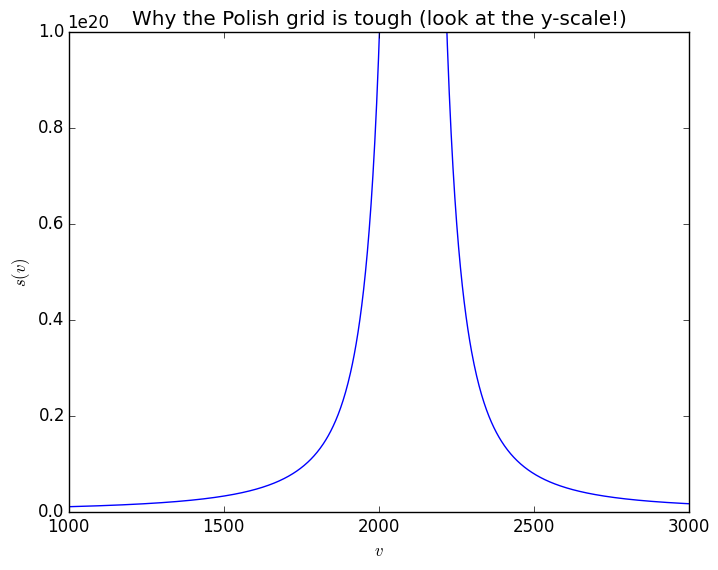

(0.0,1.0e20)

In [19]:
using JLD
d = load("secular.jld")
num = d["num"]
poles = d["poles"]
c = d["c"]
s(vv::Vector{Float64}) = [sumabs2(num./(v - poles)) for v in vv]  

xx = collect(linspace(0.0,16e3,1000))
xx = collect(linspace(1e3,3e3,1000))

plot(xx,s(xx))
title("Why the Polish grid is tough (look at the y-scale!)")
xlabel(L"v")
ylabel(L"s(v)")
ylim([0;1e20])

In [3]:
# old version of secular equation solver
# (for comparison)
function solve_secular(num,poles,c)
    tinynumber = 1e-8
    solutions = Float64[]
    vectors = Array(Vector{Float64},0)

    # pre-process poles
    poles = unique(round(poles,10))

    # sorted version of poles
    sortedpoles = sort(poles)

    find_w(num,poles,v) = float(num./(v - poles))
    s(v) = sumabs2(num./(v - poles))

    for i in 1:length(sortedpoles)

        # Head left first:
        high = sortedpoles[i]
        if length(sortedpoles) == 1
            low = 0.0 # high - high
        elseif i == 1
            low = high - abs(sortedpoles[i] - sortedpoles[i+1])
        else
            low = high - abs(sortedpoles[i] - sortedpoles[i-1])/2
        end

        # Initialize v:
        v = (high + low)/2
        w = find_w(num,poles,v)
        currentdiff = (w'*w)[1] - c
        olddiff = 0
        stall = false
        while abs(currentdiff) > tinynumber
            if currentdiff == olddiff
                stall = true
                break
            end
            if currentdiff > 0
                high = v
            else
                low = v
            end
            v = (high + low)/2
            w = find_w(num,poles,v)
            olddiff = currentdiff
            currentdiff = (w'*w)[1] - c
        end
        if !stall
            push!(solutions,v)
            push!(vectors,w)
        end

        # Now head right:
        high = sortedpoles[i]
        if length(sortedpoles) == 1
            low = high + high
        elseif i == length(sortedpoles)
            low = high + abs(sortedpoles[i] - sortedpoles[i-1])
        else
            low = high + abs(sortedpoles[i] - sortedpoles[i+1])/2
        end

        v = (high + low)/2
        w = find_w(num,poles,v)
        currentdiff = (w'*w)[1] - c
        olddiff = 0
        stall = false
        while abs(currentdiff) > tinynumber
            if currentdiff == olddiff
                stall = true
                break
            end
            if currentdiff > 0
                high = v
            else
                low = v
            end
            v = (high + low)/2
            w = find_w(num,poles,v)
            olddiff = currentdiff
            currentdiff = (w'*w)[1] - c
        end
        if !stall
            push!(solutions,v)
            push!(vectors,w)
        end
    end
    return solutions,vectors
end

solve_secular (generic function with 1 method)

## 2015-09-11

Unfortunately there is *still* a problem with my secular equation solver. When elements of `num` grow to the order of $10^10$, the method hangs. I need to build in checks so the solver handles these cases gracefully, and more importantly I need to determine the conditions under which `num` can have such large elements. Hopefully there is a natural physical interpretation.

Anyway, perhaps it is better to catch this issue one step earlier. The elements of `num` and `poles` come directly from $\hat{b}$ and $\hat{B}$. I found no correlation between the condition number of $\hat{B}_{11}$ and secular solver performance.

In [1]:
# single proc
include("../src/TemporalInstanton.jl")
using TemporalInstanton

In [3]:
inputData = load_rts96_data(return_as_type=true)

# Thermal model parameters:
inputData.Tamb = 35.0 # C
inputData.T0 = 60.0 #46.0 # initial line steady-state temp

inputData.time_values = 0.0:30.0:300.0 # five minutes in 30-sec steps
inputData.int_length = 300. # seconds = 5 min

Gp,Dp,Rp = inputData.G0,inputData.D0,inputData.R0
inputData.G0 = [0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp]
inputData.D0 = [0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp]
inputData.R0 = [Rp;1.1*Rp;1.2*Rp;1.3*Rp;1.4*Rp;1.5*Rp]

@time results = solve_temporal_instanton(inputData);
# @profile solve_temporal_instanton(inputData);
n = 73
nr = 18
T = 6
score,x,θ,α,diffs,xopt = process_instanton_results(results,
    n,
    nr,
    T);

finished 10/104
finished 20/104


finished 30/104


finished 40/104
finished 50/104
finished 60/104
finished 70/104
finished 80/104
finished 90/104
finished 100/104
finished 110/104
 10.884778 seconds (9.29 M allocations: 2.049 GB, 2.09% gc time)


In [3]:
sort(score)

104-element Array{Float64,1}:
    0.263788
    0.327316
    1.28861 
    2.20415 
    2.32297 
    2.42316 
    4.67876 
    4.86524 
    4.89917 
    5.67827 
    5.93862 
    6.43917 
    6.46089 
    ⋮       
  178.086   
  303.003   
  370.614   
  370.614   
  391.307   
  428.944   
  923.98    
  979.199   
 1319.85    
 1390.03    
 1967.27    
 1967.27    